In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import numpy as np
import IPython.display as ipd
import logging
from tqdm import tqdm
from pathlib import Path
import os
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, "../../src")
from temporal_audio_vae.datasets import LoopDataset
from temporal_audio_vae.transforms import Log1pMelSpec

logger = logging.getLogger(__name__)
logging.basicConfig(
    format="[%(asctime)s] %(levelname)s(%(name)s)\t%(message)s", level=logging.INFO
)

device = "cuda" if torch.cuda.is_available() else "cpu"
logging.info("device: %s", device)

[2024-01-17 21:18:44,593] INFO(root)	device: cuda


In [4]:
# get 5 random examples
dataset = LoopDataset(db_path="../../data/loops")
valid_ratio = 0.2
nb_valid = int(valid_ratio * len(dataset))
nb_train = len(dataset) - nb_valid
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(
    dataset, [nb_train, nb_valid]
)

print(nb_train, nb_valid)

num_threads = 0  # != 0 crashes on windows o_o
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, num_workers=num_threads
)
valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads
)

for i in np.random.randint(len(train_dataset), size=5):
    print(f"example #{i}")
    ipd.display(ipd.Audio(train_dataset[i], rate=LoopDataset.FS))

9195 2298
example #4346


example #7581


example #2122


example #3290


example #2540


In [5]:
def outsize(Lin, stride, pad, ker):
    temp = Lin - (ker - 1) - 1 + 2 * pad
    temp /= stride
    lout = np.floor(temp) + 1
    return lout

In [6]:
outsize(1024, 2, 3, 7)

512.0

In [7]:
class AE(nn.Module):
    def __init__(self, encoder, decoder, encoding_dim):
        super(AE, self).__init__()
        self.encoding_dims = encoding_dim
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
class VAE(AE):
    def __init__(self, encoder, decoder, encoding_dims, latent_dims):
        super(VAE, self).__init__(encoder, decoder, encoding_dims)
        self.latent_dims = latent_dims
        self.mu = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims))
        self.sigma = nn.Sequential(
            nn.Linear(self.encoding_dims, self.latent_dims), nn.Softplus()
        )

    def encode(self, x):
        x_encoded = self.encoder(x)

        mu = self.mu(x_encoded)
        sigma = self.sigma(x_encoded)

        return (mu, sigma)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Encode the inputs
        z_params = self.encode(x)
        # Obtain latent samples and latent loss
        z_tilde, kl_div = self.latent(z_params)
        # Decode the samples
        x_tilde = self.decode(z_tilde)
        return x_tilde, kl_div

    def latent(self, z_params):
        normal = distrib.Normal(loc=0.0, scale=1.0)
        mu, sigma = z_params
        kl_div = torch.sum(1 + torch.log(sigma**2) - mu**2 - 2 * (sigma**2)) / 2
        z = mu + sigma * normal.sample(sigma.shape).to(device)

        return z, kl_div

In [9]:
class CouchePrint(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        print(x.shape)

        return x

In [10]:
def construct_encoder_decoder(n_latent, n_hidden):
    # Encoder network
    encoder = nn.Sequential(
        nn.Conv1d(512, 256, 8, 2, 3),
        nn.LeakyReLU(),
        nn.BatchNorm1d(256),
        nn.Conv1d(256, 128, 8, 2, 3),
        nn.LeakyReLU(),
        nn.BatchNorm1d(128),
        nn.Conv1d(128, 64, 8, 2, 3),
        nn.LeakyReLU(),
        nn.BatchNorm1d(64),
        nn.Conv1d(64, 32, 8, 2, 3),
        nn.LeakyReLU(),
        nn.BatchNorm1d(32),
        nn.Conv1d(32, 16, 8, 2, 3),
        nn.LeakyReLU(),
        nn.BatchNorm1d(16),
        nn.Flatten(),
    )

    # Decoder network
    decoder = nn.Sequential(
        nn.Linear(n_latent, n_hidden),
        nn.LeakyReLU(),
        nn.Unflatten(1, torch.Size([n_latent, int(n_hidden / n_latent)])),
        nn.ConvTranspose1d(16, 32, 8, 2, 3),
        nn.LeakyReLU(),
        nn.BatchNorm1d(32),
        nn.ConvTranspose1d(32, 64, 8, 2, 3),
        nn.LeakyReLU(),
        nn.BatchNorm1d(64),
        nn.ConvTranspose1d(64, 128, 8, 2, 3),
        nn.LeakyReLU(),
        nn.BatchNorm1d(128),
        nn.ConvTranspose1d(128, 256, 8, 2, 3),
        nn.LeakyReLU(),
        nn.BatchNorm1d(256),
        nn.ConvTranspose1d(256, 512, 8, 2, 3),
        nn.LeakyReLU(),
        nn.BatchNorm1d(512),
    )
    return encoder, decoder

In [11]:
encoder_test, decoder_test = construct_encoder_decoder(n_latent=16, n_hidden=128)

In [12]:
model_test = VAE(encoder_test, decoder_test, 128, 16).to(device)

In [13]:
im_test = torch.ones((128, 512, 256)).to(device)

In [14]:
out_test, _ = model_test(im_test)

In [15]:
out_test.shape

torch.Size([128, 512, 256])

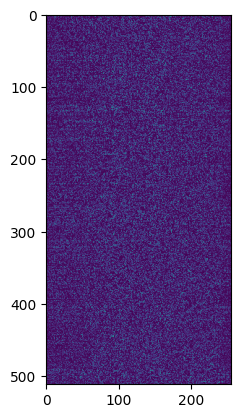

In [16]:
plt.imshow(out_test[0].detach().cpu())

In [17]:
def beta_warmup(epoch, interval, epoch_interval):
    if epoch < epoch_interval[0]:
        return interval[0]
    elif epoch > epoch_interval[1]:
        return interval[1]
    return (
        (epoch - epoch_interval[0])
        * (interval[1] - interval[0])
        / (epoch_interval[1] - epoch_interval[0])
    )

In [18]:
n_epochs = 50
n_latent = 16
n_hidden = 128
n_mels = 512
beta_interval = (0, 1)  # min, max
beta_epoch_interval = (100, 400)  # start, end
generate_every_nth_epoch = 10
evaluate_every_nth_epoch = 10
n_sounds_generated_from_dataset = 4
n_sounds_generated_from_random = 8

transform = Log1pMelSpec(
    sample_rate=LoopDataset.FS,
    n_mels=n_mels,
    n_fft=1024,
    griffin_lim_iter=64,
    hop_length=256,
    win_length=512,
).to(device)

n_frames = transform.get_n_frames(LoopDataset.LEN_SAMPLES) - 1

print("n_mels", n_mels)
print("n_frames", n_frames)

# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(n_hidden=n_hidden, n_latent=n_latent)
# Build the VAE model
model = VAE(encoder, decoder, n_hidden, n_latent).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
recons_criterion = torch.nn.MSELoss(reduction="sum")

n_mels 512
n_frames 256


d:\Documents\ATIAM\Temporal-Audio-VAE\.venv\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


In [19]:
filename = "audiovae_model_sym.pt"
logger.info("training %s", filename)
logger.info("n_epochs=%d", n_epochs)

[2024-01-17 21:19:50,207] INFO(__main__)	training audiovae_model_sym.pt
[2024-01-17 21:19:50,209] INFO(__main__)	n_epochs=50


In [20]:
class func2module(nn.Module):
    def __init__(self, f):
        super(func2module, self).__init__()
        self.f = f

    def forward(self, x):
        return self.f(x)

In [21]:
def find_normalizer(dataloader, name):
    if not os.path.isfile("min_" + name):
        minval, maxval = float("inf"), float("-inf")
        print(f"Finding {name} normalizer")
        for x in tqdm(dataloader):
            mag, _ = transform(x)
            mag = mag[:, :, : mag.shape[2] - 1]
            minval = min(minval, mag.min())
            maxval = max(maxval, mag.max())
        torch.save(minval, "min_" + name)
        torch.save(maxval, "max_" + name)
    else:
        minval = torch.load("min_" + name)
        maxval = torch.load("max_" + name)

    print(f"for {name}: {minval=:.2f}, {maxval=:.2f}")
    norm = func2module(lambda x: (x - minval) / (maxval - minval)).to(device)
    # denorm = func2module(lambda x: x * (maxval - minval) + minval).to(device)

    return norm


train_norm = find_normalizer(train_loader, "train").to(device)
valid_norm = find_normalizer(valid_loader, "valid").to(device)

for train: minval=0.00, maxval=5.38
for valid: minval=0.00, maxval=5.90


In [23]:
WRITER = SummaryWriter(comment=filename)

# add refs to tensorboard
with torch.no_grad():
    waveform = next(iter(valid_loader)).to(device)
    mag, phase = transform.forward(waveform[:n_sounds_generated_from_dataset])
    mag = mag[:, :, : mag.shape[2] - 1]
    mag = train_norm(mag)

    grid = torchvision.utils.make_grid(mag.reshape(-1, 1, n_mels, n_frames), 1)
    WRITER.add_image("ref/dataset/melspec", grid)

    WRITER.add_audio(
        "ref/dataset/original",
        waveform[:n_sounds_generated_from_dataset].reshape(-1),
        0,
        sample_rate=LoopDataset.FS,
    )

for epoch in range(1, n_epochs + 1):
    print("Epoch = {}".format(epoch))
    # TRAINING
    model.train()
    logger.info("training")

    # beta = beta_warmup(epoch, beta_interval, beta_epoch_interval)
    beta = 0

    full_loss = 0
    recons_loss = 0
    kl_div = 0

    for i, waveform in tqdm(enumerate(train_loader), desc="Train"):
        waveform = waveform.to(device)
        mag, phase = transform.forward(waveform)
        mag = mag[:, :, : mag.shape[2] - 1]
        mag = train_norm(mag)

        mag_tilde, kl_div_batch = model(mag)

        recons_loss_batch = recons_criterion(mag_tilde, mag)
        full_loss_batch = recons_loss_batch - beta * kl_div_batch

        recons_loss += recons_loss_batch
        full_loss += full_loss_batch
        kl_div += kl_div_batch

        optimizer.zero_grad()
        full_loss_batch.backward()
        optimizer.step()
    WRITER.add_scalar("loss/train/full", full_loss, epoch)
    WRITER.add_scalar("loss/train/reconstruction", recons_loss, epoch)
    WRITER.add_scalar("loss/train/kl_div", kl_div, epoch)

    model.eval()
    logger.info("evaluation")

    full_loss = 0
    recons_loss = 0
    kl_div = 0

    ## EVALUATION
    if epoch % evaluate_every_nth_epoch == 0 or epoch == n_epochs - 1:
        for i, waveform in tqdm(enumerate(valid_loader), desc="Eval"):
            waveform = waveform.to(device)
            mag, phase = transform.forward(waveform)
            mag = mag[:, :, : mag.shape[2] - 1]
            mag = valid_norm(mag)

            mag_tilde, kl_div_batch = model(mag)

            recons_loss_batch = recons_criterion(mag_tilde, mag)
            full_loss_batch = recons_loss_batch - beta * kl_div_batch

            recons_loss += recons_loss_batch
            full_loss += full_loss_batch
            kl_div += kl_div_batch

            optimizer.zero_grad()
            full_loss_batch.backward()
            optimizer.step()
        WRITER.add_scalar("loss/valid/full", full_loss, epoch)
        WRITER.add_scalar("loss/valid/reconstruction", recons_loss, epoch)
        WRITER.add_scalar("loss/valid/kl_div", kl_div, epoch)

    if epoch % generate_every_nth_epoch == 0 or epoch == n_epochs - 1:
        logger.info("generating from dataset")
        with torch.no_grad():
            waveform = next(iter(valid_loader)).to(device)
            mag, phase = transform.forward(waveform[:n_sounds_generated_from_dataset])
            mag = mag[:, :, : mag.shape[2] - 1]
            mag = train_norm(mag)
            phase = phase[:, :, : phase.shape[2] - 1]

            mag_tilde, _ = model(mag)

            waveform_tilde_copyphase = transform.backward(mag_tilde, phase)
            waveform_tilde_griffinlim = transform.backward(mag_tilde)

            grid = torchvision.utils.make_grid(
                mag_tilde.reshape(-1, 1, n_mels, n_frames), 1
            )
            WRITER.add_image("gen/dataset/melspec", grid, epoch)

            waveform_tilde_copyphase /= torch.max(abs(waveform_tilde_copyphase))
            waveform_tilde_griffinlim /= torch.max(abs(waveform_tilde_griffinlim))

            WRITER.add_audio(
                "gen/dataset/copyphase",
                waveform_tilde_copyphase.reshape(-1),
                epoch,
                sample_rate=LoopDataset.FS,
            )
            WRITER.add_audio(
                "gen/dataset/griffinlim",
                waveform_tilde_griffinlim.reshape(-1),
                epoch,
                sample_rate=LoopDataset.FS,
            )

        logger.info("generating random from latent space")
        with torch.no_grad():
            z = torch.randn(n_sounds_generated_from_random, n_latent).to(device)
            mag_tilde = model.decode(z)

            grid = torchvision.utils.make_grid(
                mag_tilde.reshape(-1, 1, n_mels, n_frames), 1
            )
            WRITER.add_image("gen/rand_latent/melspec", grid, epoch)

            waveform_tilde = transform.backward(mag_tilde)
            waveform_tilde /= torch.max(abs(waveform_tilde))

            WRITER.add_audio(
                "gen/rand_latent/griffinlim",
                waveform_tilde_griffinlim.reshape(-1),
                epoch,
                sample_rate=LoopDataset.FS,
            )
        logger.info("exploring latent space")
        with torch.no_grad():
            n_sounds_per_dimension = 5
            z = torch.zeros(n_sounds_per_dimension * n_latent, n_latent).to(device)
            for i in range(n_latent):
                a = i * n_sounds_per_dimension
                b = (i + 1) * n_sounds_per_dimension
                z[a:b, i] = torch.linspace(-2, +2, n_sounds_per_dimension)
            mag_tilde = model.decode(z)
            grid = torchvision.utils.make_grid(
                mag_tilde.reshape(-1, 1, n_mels, n_frames), n_sounds_per_dimension
            )
            WRITER.add_image("gen/explo_latent/melspec", grid, epoch)
            waveform_tilde = transform.backward(mag_tilde)
            waveform_tilde /= torch.max(abs(waveform_tilde))

            WRITER.add_audio(
                "gen/explo_latent/griffinlim",
                waveform_tilde_griffinlim.reshape(-1),
                epoch,
                sample_rate=LoopDataset.FS,
            )

[2024-01-17 21:21:38,439] INFO(__main__)	training


Epoch = 1


Train: 72it [00:12,  5.70it/s]
[2024-01-17 21:21:51,280] INFO(__main__)	evaluation
[2024-01-17 21:21:51,285] INFO(__main__)	training


Epoch = 2


Train: 72it [00:12,  5.79it/s]
[2024-01-17 21:22:03,810] INFO(__main__)	evaluation
[2024-01-17 21:22:03,816] INFO(__main__)	training


Epoch = 3


Train: 72it [00:11,  6.08it/s]
[2024-01-17 21:22:15,748] INFO(__main__)	evaluation
[2024-01-17 21:22:15,752] INFO(__main__)	training


Epoch = 4


Train: 72it [00:12,  5.87it/s]
[2024-01-17 21:22:28,114] INFO(__main__)	evaluation
[2024-01-17 21:22:28,119] INFO(__main__)	training


Epoch = 5


Train: 72it [00:11,  6.21it/s]
[2024-01-17 21:22:39,797] INFO(__main__)	evaluation
[2024-01-17 21:22:39,802] INFO(__main__)	training


Epoch = 6


Train: 72it [00:11,  6.21it/s]
[2024-01-17 21:22:51,487] INFO(__main__)	evaluation
[2024-01-17 21:22:51,491] INFO(__main__)	training


Epoch = 7


Train: 72it [00:11,  6.16it/s]
[2024-01-17 21:23:03,272] INFO(__main__)	evaluation
[2024-01-17 21:23:03,276] INFO(__main__)	training


Epoch = 8


Train: 72it [00:11,  6.19it/s]
[2024-01-17 21:23:14,991] INFO(__main__)	evaluation
[2024-01-17 21:23:14,996] INFO(__main__)	training


Epoch = 9


Train: 72it [00:11,  6.19it/s]
[2024-01-17 21:23:26,716] INFO(__main__)	evaluation
[2024-01-17 21:23:26,720] INFO(__main__)	training


Epoch = 10


Train: 72it [00:11,  6.18it/s]
[2024-01-17 21:23:38,457] INFO(__main__)	evaluation
Eval: 18it [00:03,  5.95it/s]
[2024-01-17 21:23:41,574] INFO(__main__)	generating from dataset
[2024-01-17 21:23:45,365] INFO(__main__)	generating random from latent space
[2024-01-17 21:23:46,356] INFO(__main__)	exploring latent space
[2024-01-17 21:23:53,314] INFO(__main__)	training


Epoch = 11


Train: 72it [00:11,  6.24it/s]
[2024-01-17 21:24:05,000] INFO(__main__)	evaluation
[2024-01-17 21:24:05,005] INFO(__main__)	training


Epoch = 12


Train: 72it [00:11,  6.26it/s]
[2024-01-17 21:24:16,595] INFO(__main__)	evaluation
[2024-01-17 21:24:16,600] INFO(__main__)	training


Epoch = 13


Train: 72it [00:11,  6.23it/s]
[2024-01-17 21:24:28,245] INFO(__main__)	evaluation
[2024-01-17 21:24:28,249] INFO(__main__)	training


Epoch = 14


Train: 72it [00:11,  6.24it/s]
[2024-01-17 21:24:39,882] INFO(__main__)	evaluation
[2024-01-17 21:24:39,888] INFO(__main__)	training


Epoch = 15


Train: 72it [00:11,  6.22it/s]
[2024-01-17 21:24:51,547] INFO(__main__)	evaluation
[2024-01-17 21:24:51,552] INFO(__main__)	training


Epoch = 16


Train: 72it [00:11,  6.21it/s]
[2024-01-17 21:25:03,227] INFO(__main__)	evaluation
[2024-01-17 21:25:03,231] INFO(__main__)	training


Epoch = 17


Train: 72it [00:11,  6.18it/s]
[2024-01-17 21:25:14,968] INFO(__main__)	evaluation
[2024-01-17 21:25:14,973] INFO(__main__)	training


Epoch = 18


Train: 72it [00:11,  6.14it/s]
[2024-01-17 21:25:26,785] INFO(__main__)	evaluation
[2024-01-17 21:25:26,789] INFO(__main__)	training


Epoch = 19


Train: 72it [00:11,  6.05it/s]
[2024-01-17 21:25:38,803] INFO(__main__)	evaluation
[2024-01-17 21:25:38,809] INFO(__main__)	training


Epoch = 20


Train: 72it [00:13,  5.48it/s]
[2024-01-17 21:25:52,039] INFO(__main__)	evaluation
Eval: 18it [00:03,  5.97it/s]
[2024-01-17 21:25:55,167] INFO(__main__)	generating from dataset
[2024-01-17 21:25:55,925] INFO(__main__)	generating random from latent space
[2024-01-17 21:25:56,853] INFO(__main__)	exploring latent space
[2024-01-17 21:26:03,412] INFO(__main__)	training


Epoch = 21


Train: 72it [00:12,  5.62it/s]
[2024-01-17 21:26:16,437] INFO(__main__)	evaluation
[2024-01-17 21:26:16,441] INFO(__main__)	training


Epoch = 22


Train: 72it [00:13,  5.45it/s]
[2024-01-17 21:26:29,757] INFO(__main__)	evaluation
[2024-01-17 21:26:29,762] INFO(__main__)	training


Epoch = 23


Train: 72it [00:13,  5.39it/s]
[2024-01-17 21:26:43,215] INFO(__main__)	evaluation
[2024-01-17 21:26:43,220] INFO(__main__)	training


Epoch = 24


Train: 72it [00:13,  5.44it/s]
[2024-01-17 21:26:56,563] INFO(__main__)	evaluation
[2024-01-17 21:26:56,568] INFO(__main__)	training


Epoch = 25


Train: 72it [00:13,  5.36it/s]
[2024-01-17 21:27:10,089] INFO(__main__)	evaluation
[2024-01-17 21:27:10,095] INFO(__main__)	training


Epoch = 26


Train: 72it [00:13,  5.35it/s]
[2024-01-17 21:27:23,644] INFO(__main__)	evaluation
[2024-01-17 21:27:23,649] INFO(__main__)	training


Epoch = 27


Train: 72it [00:13,  5.40it/s]
[2024-01-17 21:27:37,063] INFO(__main__)	evaluation
[2024-01-17 21:27:37,067] INFO(__main__)	training


Epoch = 28


Train: 72it [00:13,  5.33it/s]
[2024-01-17 21:27:50,676] INFO(__main__)	evaluation
[2024-01-17 21:27:50,681] INFO(__main__)	training


Epoch = 29


Train: 72it [00:13,  5.33it/s]
[2024-01-17 21:28:04,275] INFO(__main__)	evaluation
[2024-01-17 21:28:04,281] INFO(__main__)	training


Epoch = 30


Train: 72it [00:13,  5.29it/s]
[2024-01-17 21:28:17,995] INFO(__main__)	evaluation
Eval: 18it [00:03,  5.75it/s]
[2024-01-17 21:28:21,265] INFO(__main__)	generating from dataset
[2024-01-17 21:28:21,993] INFO(__main__)	generating random from latent space
[2024-01-17 21:28:22,874] INFO(__main__)	exploring latent space


In [ ]:
torch.save(model.state_dict(), filename)
logger.info("saved to %s", filename)

[2024-01-17 09:17:28,354] INFO(__main__)	saved to audiovae_test0.pt


In [ ]:
c = 0

if c == 0:
    test = torch.zeros(1, 16).to(device)
elif c == 1:
    test = torch.ones(1, 16).to(device)
elif c == 2:
    test = (
        torch.arange(0, 16, dtype=torch.get_default_dtype()).reshape(1, -1).to(device)
    )
elif c == 3:
    test = -1 * torch.ones(1, 16).to(device)
elif c == 4:
    test = 5 * torch.randn((1, 16)).to(device)
else:
    test = torch.randn((1, 16)).to(device)

In [ ]:
test

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')

In [ ]:
test_output = model.decoder(test)

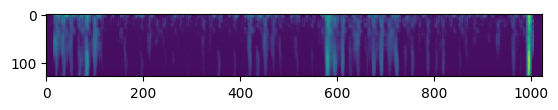

In [ ]:
plt.imshow(test_output[0].detach().cpu())

In [ ]:
test_wave = transform.backward(test_output)

In [ ]:
test_wave.shape

torch.Size([1, 65472])

In [ ]:
ipd.Audio(test_wave.cpu().detach(), rate=LoopDataset.FS)

In [ ]:
# # training loop

# # parameters
# n_epochs = 50
# beta_interval = (0, 1)  # min, max
# beta_epoch_interval = (10, 40)  # start, end
# evaluate_every_nth_epoch = 3
# generate_every_nth_epoch = 3
# n_latent = 16
# n_mels = 128
# transform = CustomTransform(
#     sample_rate=LoopDataset.FS,
#     n_mels=n_mels,
#     n_fft=1024,
#     griffin_lim_iter=64,
#     hop_length=64
# ).to(device)
# n_frames = transform.get_n_frames(LoopDataset.SIZE_SAMPLES)
# n_in = n_mels * n_frames

# print("n_mels", n_mels)
# print("n_frames", n_frames)
# print("n_in", n_in)

# filename = f"audiovae_{beta_interval[0]}_{beta_interval[1]}_{n_epochs}.pt"
# logger.info("training %s", filename)
# logger.info("n_epochs=%d", n_epochs)

# model = VAE(encoder, decoder, n_hidden, n_latent).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# recons_criterion = torch.nn.MSELoss(reduction="sum")

# if Path(filename).exists():
#     model.load_state_dict(torch.load(filename))
#     logger.info("loaded from", filename)

# else:
#     WRITER = SummaryWriter(comment=filename)

#     for epoch in range(n_epochs):
#         #beta = beta_warmup(epoch, beta_interval, beta_epoch_interval)
#         beta = 1
#         logger.info(
#             f"epoch {epoch+1}/{n_epochs}; beta={beta:.2f}; {epoch * len(train_dataset)} examples seen"
#         )
#         WRITER.add_scalar("beta", beta, epoch)

#         logger.info("training")
#         model.train()
#         full_loss = 0
#         recons_loss = 0
#         kl_div = 0
#         for i, waveform in tqdm(enumerate(train_loader), desc="Train"):
#             optimizer.zero_grad()
#             waveform = waveform.to(device)
#             mag, phase = transform.forward(waveform)
#             mag = mag[:,:,:mag.shape[2]-1]
#             mag_tilde, kl_div_batch = model(mag)
#             recons_loss_batch = recons_criterion(mag_tilde, mag)
#             full_loss_batch = recons_loss_batch - beta * kl_div_batch
#             recons_loss += recons_loss_batch
#             full_loss += full_loss_batch
#             kl_div += kl_div_batch
#             full_loss_batch.backward()
#             optimizer.step()
#         WRITER.add_scalar("loss/train/full", full_loss, epoch)
#         WRITER.add_scalar("loss/train/reconstruction", recons_loss, epoch)
#         WRITER.add_scalar("loss/train/kl_div", kl_div, epoch)

#         if epoch % evaluate_every_nth_epoch == 0 or epoch == n_epochs - 1:
#             logger.info("evaluating")
#             model.eval()
#             full_loss = 0
#             recons_loss = 0
#             kl_div = 0
#             for i, waveform in tqdm(enumerate(valid_loader), desc="Evaluation"):
#                 optimizer.zero_grad()
#                 waveform = waveform.to(device)
#                 mag, phase = transform.forward(waveform)
#                 mag = mag[:,:,:mag.shape[2]-1]
#                 mag_tilde, kl_div_batch = model(mag)
#                 recons_loss_batch = recons_criterion(mag_tilde, mag)
#                 full_loss_batch = recons_loss_batch - beta * kl_div_batch
#                 recons_loss += recons_loss_batch
#                 full_loss += full_loss_batch
#                 kl_div += kl_div_batch
#                 full_loss_batch.backward()
#                 optimizer.step()
#             WRITER.add_scalar("loss/eval/full", full_loss, epoch)
#             WRITER.add_scalar("loss/eval/reconstruction", recons_loss, epoch)
#             WRITER.add_scalar("loss/eval/kl_div", kl_div, epoch)

#         # if epoch % generate_every_nth_epoch == 0 or epoch == n_epochs - 1:
#         #     logger.info("generating from dataset")
#         #     with torch.no_grad():
#         #         n_sounds = 4
#         #         waveform = next(iter(valid_loader)).to(device)
#         #         mag, phase = transform.forward(waveform[:n_sounds])
#         #         print(f"{mag.shape=}")
#         #         print(f"{phase.shape=}")
#         #         mag = mag[:,:,:mag.shape[2]-1]
#         #         phase = phase[:,:,:phase.shape[2]-1]
#         #         print(f"{mag_tilde.shape=}")
#         #         print(f"{phase.shape=}")
#         #         mag_tilde, _ = model(mag)
#         #         mag_tilde = mag_tilde.reshape(-1, 1, n_mels, n_frames-1)
#         #         phase = phase.reshape(-1, 1, n_mels, n_frames-1)
#         #         print(f"{mag_tilde.shape=}")
#         #         print(f"{phase.shape=}")
#         #         grid = torchvision.utils.make_grid(mag_tilde, n_sounds)
#         #         WRITER.add_image("gen/dataset/melspec", grid)

#         #         waveform_tilde_copyphase = transform.backward(mag_tilde, phase)
#         #         waveform_tilde_griffinlim = transform.backward(mag_tilde)
#         #         WRITER.add_audio(
#         #             "gen/dataset/copyphase",
#         #             waveform_tilde_copyphase.reshape(-1),
#         #             epoch,
#         #             sample_rate=LoopDataset.FS,
#         #         )
#         #         WRITER.add_audio(
#         #             "gen/dataset/griffinlim",
#         #             waveform_tilde_griffinlim.reshape(-1),
#         #             epoch,
#         #             sample_rate=LoopDataset.FS,
#         #         )

#         #     logger.info("generating random from latent space")
#         #     with torch.no_grad():
#         #         n_sounds = 16
#         #         z = torch.randn(n_sounds, n_latent).to(device)
#         #         mag_tilde = model.decode(z).reshape(-1, 1, n_mels, n_frames-1)
#         #         grid = torchvision.utils.make_grid(mag_tilde, n_sounds)
#         #         WRITER.add_image("gen/rand_latent/melspec", grid)
#         #         waveform_tilde = transform.backward(mag_tilde)
#         #         WRITER.add_audio(
#         #             "gen/rand_latent/griffinlim",
#         #             waveform_tilde_griffinlim.reshape(-1),
#         #             epoch,
#         #             sample_rate=LoopDataset.FS,
#         #         )
#         #     logger.info("exploring latent space")
#         #     # with torch.no_grad():
#             #     n_sounds_per_dimension = 8
#             #     z = torch.zeros(n_sounds_per_dimension * n_latent, n_latent).to(device)
#             #     for i in range(n_latent):
#             #         a = i * n_sounds_per_dimension
#             #         b = (i + 1) * n_sounds_per_dimension
#             #         z[a:b, i] = torch.linspace(-5, +5, n_sounds_per_dimension)
#             #     mag_tilde = model.decode(z).reshape(-1, 1, n_mels, n_frames)
#             #     grid = torchvision.utils.make_grid(mag_tilde, n_sounds_per_dimension)
#             #     WRITER.add_image("gen/explo_latent/melspec", grid)
#             #     waveform_tilde = transform.backward(mag_tilde)
#             #     WRITER.add_audio(
#             #         "gen/explo_latent/griffinlim",
#             #         waveform_tilde_griffinlim.reshape(-1),
#             #         epoch,
#             #         sample_rate=LoopDataset.FS,
#             #    )

#     # save weights
#     torch.save(model.state_dict(), filename)
#     logger.info("saved to %s", filename)

[2024-01-12 18:39:07,408] INFO(__main__)	training audiovae_0_1_50.pt
[2024-01-12 18:39:07,409] INFO(__main__)	n_epochs=50


n_mels 128
n_frames 1025
n_in 131200


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\MrGoo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\MrGoo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\MrGoo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\MrGoo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\MrGoo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\MrGoo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\User